# Edge Tracing using Gaussian Process Regression Demonstration

### This notebook

- Abstract of paper and more information on publication of methodology.
- Description of input parameters and pseudocode of algorithm.
- Code demonstration of algorithm on noisy example from [paper](https://arxiv.org/abs/2111.03605)

---

### Abstract

We introduce a novel edge tracing algorithm using Gaussian process regression. Our edge-based segmentation algorithm models an edge of interest using Gaussian process regression and iteratively searches the image for edge pixels in a recursive Bayesian scheme. This procedure combines local edge information from the image gradient and global structural information from posterior curves, sampled from the model's posterior predictive distribution, to sequentially build and refine an observation set of edge pixels. This accumulation of pixels converges the distribution to the edge of interest. Hyperparameters can be tuned by the user at initialisation and optimised given the refined observation set. This tunable approach does not require any prior training and is not restricted to any particular type of imaging domain. Due to the model's uncertainty quantification, the algorithm is robust to artefacts and occlusions which degrade the quality and continuity of edges in images. Our approach also has the ability to efficiently trace edges in image sequences by using previous-image edge traces as a priori information for consecutive images. Various applications to medical imaging and satellite imaging are used to validate the technique and comparisons are made with two commonly used edge tracing algorithms.

### More information

Paper which describes this methodology has been accepted to be published in IEEE Transactions on Image Processing in December 2021 or January 2022 (TBC).

For open access to this paper for information on the algorithm, pseudocode, applications and discussion, see [here](https://arxiv.org/abs/2111.03605)

---
### Parameters

#### Model parameters in `__init__()` functon

##### Compulsory parameters

* `init` (`2darray`, compulsory input) : Pixel coordinates of the edge of interest. This is inputted in $xy$-space, i.e. `init=np.array([[st_x, st_y],[en_x, en_y]])`.

            
* `grad_img` (`2darray`, compulsory input) : Estimated edge map, or image gradient. This is normalised to $[0,1]$.  


* `kernel_options` (`dict` or `3-tuple`, compulsory input) : Kernel type and hyperparameters. Only  the square exponential and Matern class are implemented. Format of dict is, for example, `{'kernel_type':'RBF', 'sigma_f':50, 'length_scale':100}` for the square exponential kernel. If inputting 3-tuple, format is $(k, s, l)$ where $k=0,1$ (RBF, Matern), $s,l=0,...5$, define scales of function variance and lengthscale, chosen according to the image height and edge of interest length, respectively.

##### Tuning parameters

* `noise_y` (`float`, default `1`) : Amount of noise to perturb the posterior samples drawn from Gaussian process from the observation set.


* `obs` (2darray, default `np.array([])`) : $xy$-space observations to fit to the Gaussian process. User-specified at initialisation when propagating edge pixels from a different edge to improve accuracy and quicken convergence of the current edge of interest (see [section 4.4](https://arxiv.org/abs/2111.03605)). Otherwise, this parameter is used in the recursive Bayesian scheme to converge posterior predictive distribution to edge of interest.


* `N_sample` (`int`, default `1000`) : Number of posterior curves to sample from the Gaussian process in each iteration. 


* `score_thresh` (`float`, default `1`) : Initial pixel score to determine which observations to accept and fit to the Gaussian process in each iteration.


* `delta_x` (`int`, default `5`) : Length of sub-intervals to split horizontal, $x$-axis during search for edge pixels. Number of subintervals=`N//delta_x`, where $N$ is the width of the image. Algorithm terminates after `N//delta_x` are located and fitted to Gaussian process. 


* `keep_ratio` (`float`, default `0.1`) : Proportion of posterior curves, coined as optimal, to use to score pixels and select new observations for next iteration. Value must be in $(0, 1]$.

##### Randomisation and Output Parameters


* `seed` (`int`, default `1`) : Integer to fix random sampling of posterior curves from Gaussian Process in each iteration.  


* `return_std` (`bool` default `False`) : If flagged, return 95% credible interval as well as edge trace prediction.


* `fix_endpoints` (`bool` default `False`) : If flagged, user-inputted edge endpoints `init` are fixed (negligible observation noise is chosen for these pixels).

#### Verbosity Parameters
##### Parameters in `__call__()` function

* `print_final_diagnostics` (`bool`, default `False`) : If flaged, print diagnostics at the end; plot of edge prediction with/without 95% credible interval on inputted image gradient and plot of iteration vs. cost.


* `show_init_post` (`bool` default `False`) : If flagged, show initial posterior predictive distribution (after fitting `init` (and `obs`) and ask use to continue or not.


* `show_post_iter` (`bool` default `False`) : If flagged, show the posterior predictive distribution during each iteration of the fitting procedure.


* `verbose` (`bool` default `False`) : If flagged, output text updating user on time/iter, number of observations/iter and any adaptive score threshold reduction.

---
### Demonstration with Code

In [1]:
# Import relevant python packages
import numpy as np
from gp_edge_tracing import gpet_utils, gpet
import matplotlib.pyplot as plt
%matplotlib inline

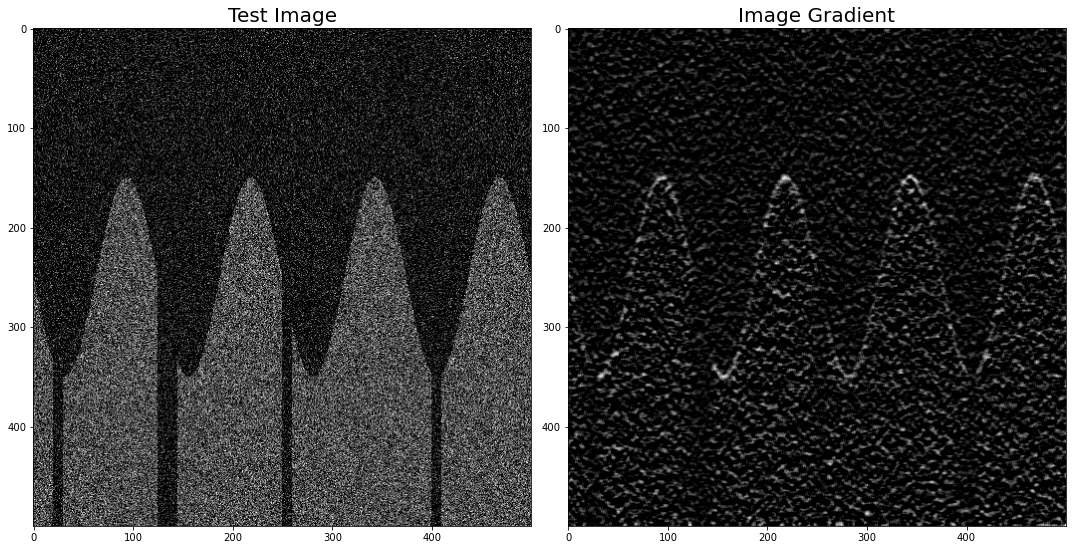

In [2]:
# Create test image with single sinusoidal edge and simple image gradient
N = 500
test_img, true_edge = gpet_utils.construct_test_img(size=(N,N), amplitude=200, curvature=4, noise_level=0.05, ltype='sinusoidal', intensity=0.3, gaps=True)

kernel = gpet_utils.kernel_builder(size=(11,5), unit=False)
grad_img = gpet_utils.comp_grad_img(test_img, kernel)

# Plot test image and image gradient
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.imshow(test_img, cmap='gray', vmin=0, vmax=1)
ax1.set_title('Test Image', fontsize=20)
ax2= fig.add_subplot(122)
ax2.imshow(grad_img, cmap='gray', vmin=0, vmax=1)
ax2.set_title('Image Gradient', fontsize=20)
fig.tight_layout()
fig.savefig('Figures/test_img_grad.png')

In [3]:
# Define model parameters
kernel_params = {'kernel': 'RBF', 'sigma_f': 75, 'length_scale': 20}
delta_x = 5
score_thresh = 1
N_samples = 1000
noise_y = 1
seed = 1
keep_ratio = 0.1
init = true_edge[[0, -1],:][:, [1,0]]
obs = np.array([])
fix_endpoints=True
return_std = True

# Instantiate algorithm using parameters in __init__()
noisy_trace = gpet.GP_Edge_Tracing(init, grad_img, kernel_params, noise_y, obs, N_samples, score_thresh,
                                   delta_x, keep_ratio, seed, return_std, fix_endpoints)

# __call__() parameters and run algorithm on test image
# Change these verbosity parameters to monitor fitting procedure
print_final_diagnostics = False
show_init_post = False
show_post_iter = False
verbose = False
edge_pred, edge_credint = noisy_trace(print_final_diagnostics, show_init_post, show_post_iter, verbose)

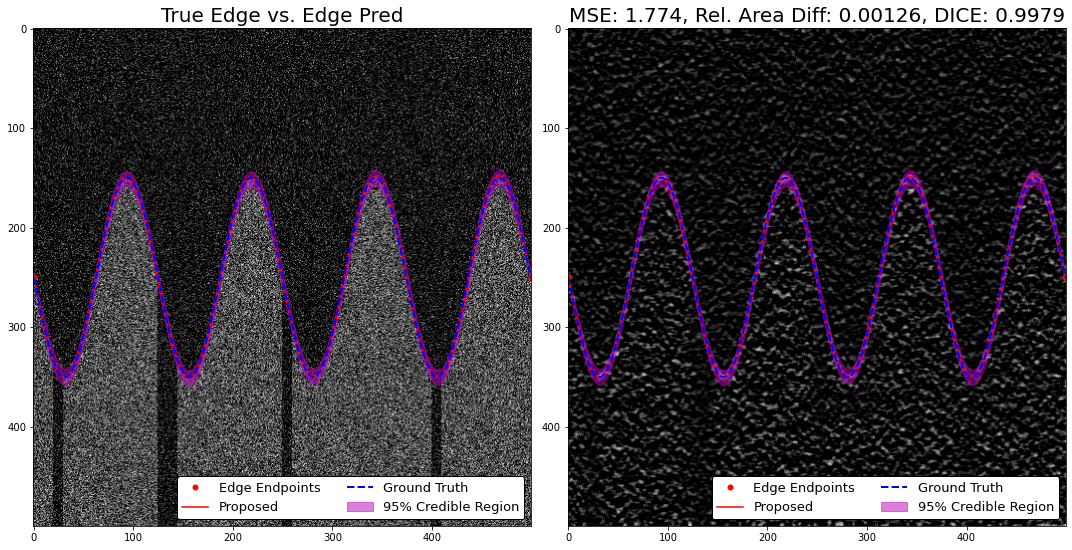

In [4]:
fig = gpet_utils.plot_results(edge_pred, true_edge, test_img, grad_img, edge_credint)
fig.savefig('Figures/noisy_trace_results.png')